# DISTILBERT Multilanguage

#### Configure NVIDIA GPU as Default

In [2]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

Number of GPU:  1
GPU Name:  NVIDIA GeForce GTX 1650
GPU: NVIDIA GeForce GTX 1650 is available.


In [3]:
#Configure device: Set the device configuration to GPU using the torch.device class in PyTorch:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


### Importing Library

In [4]:
import pandas as pd
import numpy as np

### Load Data

In [5]:
df = pd.read_csv('bca_preprocessed_half.csv', delimiter=',')
df.head(5)

,content,score,sentiment
0,pelayanan buruk trouble tidak ada info era dig...,1,0
1,kenapa sih ini verif aplikasinya susah banget ...,1,0
2,notifikasi transaksi tidak bisa di edit hapus ...,1,0
3,tidak bisa dibuka selalu force close talkback ...,1,0
4,ok bagus dan membantun,5,2


In [6]:
df.shape

(7000, 3)

### Find and clean missing data pt2

In [7]:
df.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [8]:
bca_clean_again = df.dropna()

In [9]:
bca_clean_again.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [10]:
bca_clean_again.shape

(7000, 3)

### Check Data Balance when Splitting🪓

In [11]:
#Split features (content) and labels (sentiment)

X = bca_clean_again['content']
y = bca_clean_again['sentiment']

In [12]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("Before balancing:")
print(y.value_counts())

Before balancing:
sentiment
0    4181
2    2188
1     631
Name: count, dtype: int64


##### Melakukan balancing data karena kelas 0 mempunyai values yang sedikit dan dapat berpengaruh kepada performa yang tidak baik menggunakan Oversampling: duplikasi class minoritas untuk menyeimbangkan dataset.

In [13]:
# Oversampling technique
from sklearn.utils import resample


bca_clean_again = pd.concat([X, y], axis=1)

#separating each class

class_0 = bca_clean_again[bca_clean_again['sentiment'] == 0]
class_1 = bca_clean_again[bca_clean_again['sentiment'] == 1]
class_2 = bca_clean_again[bca_clean_again['sentiment'] == 2]

#oversampling neutral class 1 with majority class 2

class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)

#combine all class
bca_clean_again = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

#shuffling the data
bca_clean_again = bca_clean_again.sample(frac=1, random_state=42)

X = bca_clean_again['content']
y = bca_clean_again['sentiment']

In [14]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("After balancing:")
print(y.value_counts())

After balancing:
sentiment
0    4181
2    4181
1    4181
Name: count, dtype: int64


### Splitting Data🪓🪓🪓 , 80:20 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

#split 20% test+validation into 10%test dan 10%validation test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                               test_size=0.5, random_state=42,stratify=y_temp)

In [16]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 10034
Validation set size: 1254
Test set size: 1255


#### Build Tokenizer with custom tune DistilBERT

In [17]:
# import transformer library
from transformers import AutoTokenizer, DistilBertModel, DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")

#### Convert Dataset to Hugging Face Format

In [18]:
from datasets import Dataset

def convert_dataset(X, y):
    return Dataset.from_pandas(pd.DataFrame({"text": X, "label": y}))

train_dataset = convert_dataset(X_train, y_train)
validation_dataset = convert_dataset(X_val, y_val)
test_dataset = convert_dataset(X_test, y_test)

label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

print(train_dataset[0])

{'text': 'kecewa sekali kenapa sekarang selalu verivikasi data terusmenyusahkan saja', 'label': 0, '__index_level_0__': 6277}


#### Create tokenizer function

In [19]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

#apply tokenizer to datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset= test_dataset.map(tokenize_function, batched=True)

# Remove text column as it's no longer needed
train_dataset = train_dataset.remove_columns(["text"])
validation_dataset = validation_dataset.remove_columns(["text"])
test_dataset= test_dataset.remove_columns(["text"])

# Convert labels to int format
train_dataset = train_dataset.with_format("torch")
validation_dataset  = validation_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

Map:   0%|          | 0/10034 [00:00<?, ? examples/s]

Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

Map:   0%|          | 0/1255 [00:00<?, ? examples/s]

In [20]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

#### Define Trainer and looping

In [21]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
import optuna
import torch
import gc

# make sure it sets to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 3e-5)
    num_train_epochs = trial.suggest_int("num_train_epochs", 4, 5)
    batch_size = trial.suggest_categorical("batch_size", [4, 8])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-3)
    max_grad_norm = trial.suggest_loguniform("max_grad_norm", 0.5, 1.0)
    gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 2, 4)

    # Clear GPU memory before trial
    gc.collect()
    torch.cuda.empty_cache()
    
    # load model
    model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-multilingual-cased",
                                                            num_labels=3).to(device)

    # enable gpu optimizations
    torch.backends.cudnn.benchmark = True
    model.gradient_checkpointing_enable()  # Reduces memory usage during training

    training_args = TrainingArguments(
        output_dir='./distilbert_optuna_result',
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs, #increase epochs
        per_device_train_batch_size=batch_size, #train batch size
        per_device_eval_batch_size=batch_size,  #eval batch size
        eval_strategy="epoch", # Evaluate model at the end of each steps
        save_strategy="epoch",  # Set save_strategy to "steps"
        warmup_steps=50,# increase learning rate every 100 steps
        lr_scheduler_type="linear",
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=500, # to save memory
        fp16=False, #Gpu Optimization if capable yes, if not FALSE
        push_to_hub=False,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        gradient_accumulation_steps=gradient_accumulation_steps, #simulates larger batch size
        report_to="none", 
        max_grad_norm=max_grad_norm  # clips gradient to prevent explosions
    )
    optuna_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # train model
    optuna_trainer.train()
    eval_result = optuna_trainer.evaluate(validation_dataset)

    # Clean up memory after each trial
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return eval_result.get("eval_accuracy", 0)

# Create study
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=1, n_warmup_steps=1))
study.optimize(objective, n_trials=3)

best_params = study.best_params
print("Best Hyperparameters:", study.best_params)
print("Best Trial:", study.best_trial)

df_result = study.trials_dataframe()
df_result = df_result[['number', 'value','params_batch_size', 'params_gradient_accumulation_steps',
                       'params_learning_rate', 'params_max_grad_norm',
                       'params_num_train_epochs', 'params_weight_decay', 'state']]

df_result.columns = ['Trial','Train Accuracy','Batch Size','Grad Accumulation Steps','Learning Rate', 'Max Grad Norm',
                     'Epochs','Weight Decay','Status']

# print as tables
print(df_result.to_string(index=False))

[I 2025-03-08 12:07:28,410] A new study created in memory with name: no-name-283415e2-f274-4084-b234-41eea21ee73b
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 3e-5)
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-3)
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

  0%|          | 0/1565 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.707910418510437, 'eval_accuracy': 0.7001594896331739, 'eval_runtime': 11.7276, 'eval_samples_per_second': 106.927, 'eval_steps_per_second': 13.387, 'epoch': 1.0}
{'loss': 0.7909, 'grad_norm': 42.31207275390625, 'learning_rate': 1.4556989503617741e-05, 'epoch': 1.6}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.4619300365447998, 'eval_accuracy': 0.8229665071770335, 'eval_runtime': 11.5046, 'eval_samples_per_second': 109.0, 'eval_steps_per_second': 13.647, 'epoch': 2.0}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.3662399649620056, 'eval_accuracy': 0.8676236044657097, 'eval_runtime': 11.5456, 'eval_samples_per_second': 108.613, 'eval_steps_per_second': 13.598, 'epoch': 3.0}
{'loss': 0.3586, 'grad_norm': 29.48398780822754, 'learning_rate': 7.722722131027254e-06, 'epoch': 3.19}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.36514535546302795, 'eval_accuracy': 0.879585326953748, 'eval_runtime': 11.4502, 'eval_samples_per_second': 109.517, 'eval_steps_per_second': 13.712, 'epoch': 4.0}
{'loss': 0.1796, 'grad_norm': 52.81742477416992, 'learning_rate': 8.884547584367636e-07, 'epoch': 4.79}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.3410923182964325, 'eval_accuracy': 0.8923444976076556, 'eval_runtime': 11.4111, 'eval_samples_per_second': 109.893, 'eval_steps_per_second': 13.759, 'epoch': 5.0}
{'train_runtime': 1813.632, 'train_samples_per_second': 27.663, 'train_steps_per_second': 0.863, 'train_loss': 0.4308215400281425, 'epoch': 5.0}


  0%|          | 0/157 [00:00<?, ?it/s]

[I 2025-03-08 12:37:55,484] Trial 0 finished with value: 0.8923444976076556 and parameters: {'learning_rate': 2.0707830138949183e-05, 'num_train_epochs': 5, 'batch_size': 8, 'weight_decay': 0.00023405375271964805, 'max_grad_norm': 0.6733374360239508, 'gradient_accumulation_steps': 4}. Best is trial 0 with value: 0.8923444976076556.
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 3e-5)
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("wei

  0%|          | 0/3344 [00:00<?, ?it/s]

{'loss': 0.9425, 'grad_norm': 37.09247589111328, 'learning_rate': 1.3864406879224733e-05, 'epoch': 0.6}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.653180718421936, 'eval_accuracy': 0.74481658692185, 'eval_runtime': 10.6197, 'eval_samples_per_second': 118.082, 'eval_steps_per_second': 29.568, 'epoch': 1.0}
{'loss': 0.7181, 'grad_norm': 44.53214645385742, 'learning_rate': 1.1426923250669049e-05, 'epoch': 1.19}
{'loss': 0.4941, 'grad_norm': 26.401294708251953, 'learning_rate': 8.989439622113366e-06, 'epoch': 1.79}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.46868905425071716, 'eval_accuracy': 0.8141945773524721, 'eval_runtime': 10.6399, 'eval_samples_per_second': 117.859, 'eval_steps_per_second': 29.512, 'epoch': 2.0}
{'loss': 0.3613, 'grad_norm': 99.07708740234375, 'learning_rate': 6.551955993557681e-06, 'epoch': 2.39}
{'loss': 0.2866, 'grad_norm': 24.31690788269043, 'learning_rate': 4.114472365001995e-06, 'epoch': 2.99}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.3780194818973541, 'eval_accuracy': 0.8716108452950558, 'eval_runtime': 10.7634, 'eval_samples_per_second': 116.506, 'eval_steps_per_second': 29.173, 'epoch': 3.0}
{'loss': 0.2176, 'grad_norm': 16.408700942993164, 'learning_rate': 1.676988736446311e-06, 'epoch': 3.58}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.4070495367050171, 'eval_accuracy': 0.8748006379585327, 'eval_runtime': 10.5473, 'eval_samples_per_second': 118.893, 'eval_steps_per_second': 29.771, 'epoch': 4.0}
{'train_runtime': 1584.3026, 'train_samples_per_second': 25.334, 'train_steps_per_second': 2.111, 'train_loss': 0.47228697042145795, 'epoch': 4.0}


  0%|          | 0/314 [00:00<?, ?it/s]

[I 2025-03-08 13:04:32,312] Trial 1 finished with value: 0.8748006379585327 and parameters: {'learning_rate': 1.605814214492485e-05, 'num_train_epochs': 4, 'batch_size': 4, 'weight_decay': 0.0003319151715914076, 'max_grad_norm': 0.6181978735981282, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 0.8923444976076556.
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 3e-5)
C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\1782534341.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weigh

  0%|          | 0/6270 [00:00<?, ?it/s]

{'loss': 0.9371, 'grad_norm': 12.506147384643555, 'learning_rate': 2.3216214833029058e-05, 'epoch': 0.4}
{'loss': 0.7487, 'grad_norm': 15.757850646972656, 'learning_rate': 2.12044111213281e-05, 'epoch': 0.8}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5324914455413818, 'eval_accuracy': 0.7799043062200957, 'eval_runtime': 11.0046, 'eval_samples_per_second': 113.953, 'eval_steps_per_second': 28.534, 'epoch': 1.0}
{'loss': 0.5456, 'grad_norm': 4.932614803314209, 'learning_rate': 1.9192607409627145e-05, 'epoch': 1.2}
{'loss': 0.4104, 'grad_norm': 2.837205410003662, 'learning_rate': 1.7180803697926185e-05, 'epoch': 1.59}
{'loss': 0.3692, 'grad_norm': 24.916194915771484, 'learning_rate': 1.5168999986225228e-05, 'epoch': 1.99}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.3983236849308014, 'eval_accuracy': 0.8700159489633174, 'eval_runtime': 11.0752, 'eval_samples_per_second': 113.226, 'eval_steps_per_second': 28.352, 'epoch': 2.0}
{'loss': 0.2637, 'grad_norm': 1.097480297088623, 'learning_rate': 1.3157196274524268e-05, 'epoch': 2.39}
{'loss': 0.2526, 'grad_norm': 0.041768878698349, 'learning_rate': 1.114539256282331e-05, 'epoch': 2.79}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5464336276054382, 'eval_accuracy': 0.8883572567783095, 'eval_runtime': 11.0738, 'eval_samples_per_second': 113.241, 'eval_steps_per_second': 28.355, 'epoch': 3.0}
{'loss': 0.2254, 'grad_norm': 39.54426956176758, 'learning_rate': 9.133588851122352e-06, 'epoch': 3.19}
{'loss': 0.1721, 'grad_norm': 133.8640594482422, 'learning_rate': 7.121785139421393e-06, 'epoch': 3.59}
{'loss': 0.1591, 'grad_norm': 0.07623884081840515, 'learning_rate': 5.109981427720435e-06, 'epoch': 3.98}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5134941339492798, 'eval_accuracy': 0.9138755980861244, 'eval_runtime': 11.0945, 'eval_samples_per_second': 113.029, 'eval_steps_per_second': 28.302, 'epoch': 4.0}
{'loss': 0.0891, 'grad_norm': 0.01667432300746441, 'learning_rate': 3.098177716019476e-06, 'epoch': 4.38}
{'loss': 0.0836, 'grad_norm': 354.06890869140625, 'learning_rate': 1.0863740043185177e-06, 'epoch': 4.78}


  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5549994707107544, 'eval_accuracy': 0.9138755980861244, 'eval_runtime': 10.946, 'eval_samples_per_second': 114.562, 'eval_steps_per_second': 28.686, 'epoch': 5.0}
{'train_runtime': 2114.6911, 'train_samples_per_second': 23.725, 'train_steps_per_second': 2.965, 'train_loss': 0.3424697039420145, 'epoch': 5.0}


  0%|          | 0/314 [00:00<?, ?it/s]

[I 2025-03-08 13:40:00,141] Trial 2 finished with value: 0.9138755980861244 and parameters: {'learning_rate': 2.5026838173559924e-05, 'num_train_epochs': 5, 'batch_size': 4, 'weight_decay': 0.00010148240166534687, 'max_grad_norm': 0.8837484398572918, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 0.9138755980861244.


Best Hyperparameters: {'learning_rate': 2.5026838173559924e-05, 'num_train_epochs': 5, 'batch_size': 4, 'weight_decay': 0.00010148240166534687, 'max_grad_norm': 0.8837484398572918, 'gradient_accumulation_steps': 2}
Best Trial: FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.9138755980861244], datetime_start=datetime.datetime(2025, 3, 8, 13, 4, 32, 313299), datetime_complete=datetime.datetime(2025, 3, 8, 13, 40, 0, 141424), params={'learning_rate': 2.5026838173559924e-05, 'num_train_epochs': 5, 'batch_size': 4, 'weight_decay': 0.00010148240166534687, 'max_grad_norm': 0.8837484398572918, 'gradient_accumulation_steps': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=3e-05, log=True, low=1e-05, step=None), 'num_train_epochs': IntDistribution(high=5, log=False, low=4, step=1), 'batch_size': CategoricalDistribution(choices=(4, 8)), 'weight_decay': FloatDistribution(high=0.001, log=True, low=0.0001, step=None), 'max

In [22]:
# visualize hyperparameter importance

import optuna.visualization as vis

def opt_visualize(study):
    vis.plot_param_importances(study).show()
    vis.plot_parallel_coordinate(study).show()

opt_visualize(study)

#### Retune using best checkpoint

In [27]:
import os

checkpoint_dir = "./distilbert_optuna_result/"

# List all checkpoint folders
checkpoints = [ckpt for ckpt in os.listdir(checkpoint_dir) if ckpt.startswith("checkpoint-")]
checkpoints.sort(key=lambda x: int(x.split("-")[-1]))  # Sort by step number

print("Available Checkpoints:", checkpoints)

Available Checkpoints: ['checkpoint-313', 'checkpoint-626', 'checkpoint-837', 'checkpoint-939', 'checkpoint-1252', 'checkpoint-1255', 'checkpoint-1565', 'checkpoint-1674', 'checkpoint-2510', 'checkpoint-2511', 'checkpoint-3344', 'checkpoint-3765', 'checkpoint-5020', 'checkpoint-6270']


In [34]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 # Clear GPU memory before trial
gc.collect()
torch.cuda.empty_cache()

# Get best hyperparameters from Optuna
best_params = study.best_params

# Reinitialize the model from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert_optuna_result/checkpoint-6270", num_labels=3).to(device)

# enable gpu optimizations
torch.backends.cudnn.benchmark = True
model.gradient_checkpointing_enable()  # Reduces memory usage during training

# Load tokenizer again
tokenizer = AutoTokenizer.from_pretrained("distilbert_optuna_result/checkpoint-6270")

# Define final training arguments
training_args = TrainingArguments(
    output_dir="./final_distilbert_model",
    learning_rate=best_params["learning_rate"],
    num_train_epochs=best_params["num_train_epochs"],
    per_device_train_batch_size=best_params["batch_size"],
    weight_decay=best_params["weight_decay"],
    gradient_accumulation_steps=best_params["gradient_accumulation_steps"],
    max_grad_norm=best_params["max_grad_norm"],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer, # pass tokenizer
    compute_metrics=compute_metrics,
)

# Train the model from scratch with the best hyperparameters
trainer.train()

# Evaluate best checkpoint
eval_results = trainer.evaluate()
print("Evaluation of Best of Optuna Hyperparamater:", eval_results)

c:\Users\Darren\anaconda3\envs\pytorch_nvidia\lib\site-packages\transformers\training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

C:\Users\Darren\AppData\Local\Temp\ipykernel_20792\2609764448.py:42: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



  0%|          | 0/6270 [00:00<?, ?it/s]

{'loss': 0.194, 'grad_norm': 0.008460951037704945, 'learning_rate': 2.303107755365881e-05, 'epoch': 0.4}
{'loss': 0.1797, 'grad_norm': 0.035186801105737686, 'learning_rate': 2.1035316933757702e-05, 'epoch': 0.8}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.6892140507698059, 'eval_accuracy': 0.8859649122807017, 'eval_runtime': 11.5954, 'eval_samples_per_second': 108.146, 'eval_steps_per_second': 13.54, 'epoch': 1.0}
{'loss': 0.178, 'grad_norm': 0.018358007073402405, 'learning_rate': 1.9039556313856593e-05, 'epoch': 1.2}
{'loss': 0.1131, 'grad_norm': 0.14439590275287628, 'learning_rate': 1.7043795693955483e-05, 'epoch': 1.59}
{'loss': 0.1243, 'grad_norm': 36.065162658691406, 'learning_rate': 1.5048035074054372e-05, 'epoch': 1.99}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.5822359919548035, 'eval_accuracy': 0.9138755980861244, 'eval_runtime': 11.6089, 'eval_samples_per_second': 108.02, 'eval_steps_per_second': 13.524, 'epoch': 2.0}
{'loss': 0.0858, 'grad_norm': 97.57933807373047, 'learning_rate': 1.305227445415326e-05, 'epoch': 2.39}
{'loss': 0.0895, 'grad_norm': 0.009438781999051571, 'learning_rate': 1.1056513834252152e-05, 'epoch': 2.79}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.6251575946807861, 'eval_accuracy': 0.9258373205741627, 'eval_runtime': 11.6436, 'eval_samples_per_second': 107.699, 'eval_steps_per_second': 13.484, 'epoch': 3.0}
{'loss': 0.0566, 'grad_norm': 0.0021731038577854633, 'learning_rate': 9.060753214351041e-06, 'epoch': 3.19}
{'loss': 0.0312, 'grad_norm': 0.0019471176201477647, 'learning_rate': 7.06499259444993e-06, 'epoch': 3.59}
{'loss': 0.0408, 'grad_norm': 0.8173472881317139, 'learning_rate': 5.0692319745488204e-06, 'epoch': 3.98}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.6843757033348083, 'eval_accuracy': 0.919457735247209, 'eval_runtime': 11.7286, 'eval_samples_per_second': 106.918, 'eval_steps_per_second': 13.386, 'epoch': 4.0}
{'loss': 0.0278, 'grad_norm': 0.0013716109097003937, 'learning_rate': 3.07347135464771e-06, 'epoch': 4.38}
{'loss': 0.0308, 'grad_norm': 0.002027588663622737, 'learning_rate': 1.0777107347465997e-06, 'epoch': 4.78}


  0%|          | 0/157 [00:00<?, ?it/s]

{'eval_loss': 0.6351852416992188, 'eval_accuracy': 0.9242424242424242, 'eval_runtime': 11.6148, 'eval_samples_per_second': 107.965, 'eval_steps_per_second': 13.517, 'epoch': 5.0}
{'train_runtime': 2031.8397, 'train_samples_per_second': 24.692, 'train_steps_per_second': 3.086, 'train_loss': 0.09331738595186809, 'epoch': 5.0}


  0%|          | 0/157 [00:00<?, ?it/s]

Evaluation of Best of Optuna Hyperparamater: {'eval_loss': 0.6251575946807861, 'eval_accuracy': 0.9258373205741627, 'eval_runtime': 11.6372, 'eval_samples_per_second': 107.758, 'eval_steps_per_second': 13.491, 'epoch': 4.996412913511359}


#### Evaluate Retuned with Optuna

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_test, preds) *100

#print classification report
print("DistilBERT with Optuna Retune classification Report")
print(f"Test Accuracy: {accuracy:.2f}%\n")
print(classification_report(y_test, preds, target_names=list(label_map.values())))

  0%|          | 0/157 [00:00<?, ?it/s]

DistilBERT with Optuna Retune classification Report
Test Accuracy: 92.11%

              precision    recall  f1-score   support

    Negative       0.91      0.86      0.88       418
     Neutral       0.96      1.00      0.98       418
    Positive       0.89      0.91      0.90       419

    accuracy                           0.92      1255
   macro avg       0.92      0.92      0.92      1255
weighted avg       0.92      0.92      0.92      1255



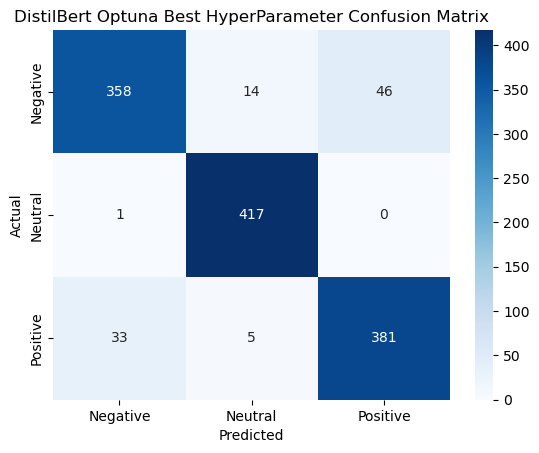

In [42]:
# confusion matrix

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBert Optuna Best HyperParameter Confusion Matrix")
plt.show()

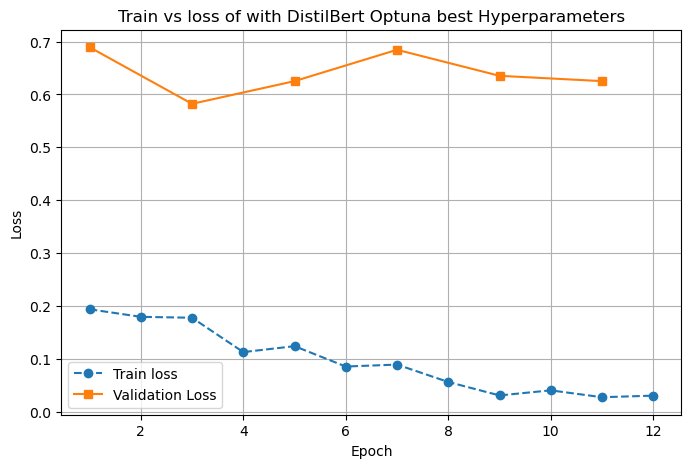

In [108]:
# train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
# eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Generate epochs in range
train_steps = list(range(1, len(train_loss) + 1))
eval_epochs = list(range(1, len(eval_loss) * (len(train_loss) // len(eval_loss)) + 1, len(train_loss) // len(eval_loss)))

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label="Train loss", marker="o", linestyle="dashed")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs loss of with DistilBert Optuna best Hyperparameters")
plt.legend()
plt.grid()
plt.show()

In [101]:
import json

for checkpoint in ["3765", "5020", "6270"]:
    log_file = f"final_distilbert_model/checkpoint-{checkpoint}/trainer_state.json"
    with open(log_file) as f:
        logs = json.load(f)
    eval_losses = [log["eval_loss"] for log in logs["log_history"] if "eval_loss" in log]
    print(f"Checkpoint-{checkpoint}: Last Eval Loss = {eval_losses[-1]}")

Checkpoint-3765: Last Eval Loss = 0.6251575946807861
Checkpoint-5020: Last Eval Loss = 0.6843757033348083
Checkpoint-6270: Last Eval Loss = 0.6351852416992188


###### Saving model

In [80]:
best_checkpoint_path = "./final_distilbert_model/checkpoint-3765"

model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)
trainer.save_pretrained("distilbert_optuna_final_best_model")
tokenizer.save_pretrained("distilbert_optuna_final_best_model")

('distilbert_optuna_final_best_model\\tokenizer_config.json',
 'distilbert_optuna_final_best_model\\special_tokens_map.json',
 'distilbert_optuna_final_best_model\\vocab.txt',
 'distilbert_optuna_final_best_model\\added_tokens.json',
 'distilbert_optuna_final_best_model\\tokenizer.json')

#### Inference Test and using dataset

In [102]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to use {device}")

# Load model & tokenizer
model_name = "distilbert_optuna_final_best_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load dynamic neutral threshold
neutral_low, neutral_high = np.load("neutral_threshold.npy")
print(f"Loaded Neutral Threshold: low={neutral_low:.4f}, high={neutral_high:.4f}")

# Define classifier pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# Label mapping
label_map = {"LABEL_0": "NEGATIVE", "LABEL_1": "NEUTRAL", "LABEL_2": "POSITIVE"}

# Inference function
def predict_with_dynamic_threshold(texts):
    predictions = classifier(texts)

    for text, scores in zip(texts, predictions):
        # Extract confidence scores
        negative_score = scores[0]['score']
        neutral_score = scores[1]['score']
        positive_score = scores[2]['score']

        # Apply neutral threshold logic
        if neutral_low < neutral_score < neutral_high:
            best_label = "NEUTRAL"
            confidence = neutral_score
        else:
            best_pred = max(scores, key=lambda x: x['score'])  # Find highest confidence
            best_label = label_map[best_pred['label']]
            confidence = best_pred['score']

        # Print result in the required format
        print(f"\nText: {text}")
        print(f"Sentiment: {best_label} ('Confidence Score': {confidence:.6f}')")

# Example inference
texts = ["Transaksinya dipersulit gimana sih BCA", "Amazing app thank you BCA"]
predict_with_dynamic_threshold(texts)


Device set to use cuda


Device set to use cuda:0


Loaded Neutral Threshold: low=0.3000, high=0.6761

Text: Transaksinya dipersulit gimana sih BCA
Sentiment: NEGATIVE ('Confidence Score': 0.999960')

Text: Amazing app thank you BCA
Sentiment: POSITIVE ('Confidence Score': 0.999978')


In [105]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import pandas as pd

# Load best checkpoint model & tokenizer
model_name = "distilbert_optuna_final_best_model"  # Update with your best checkpoint
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None)

# Label mapping
label_map = {"LABEL_0": "NEGATIVE", "LABEL_1": "NEUTRAL", "LABEL_2": "POSITIVE"}

# Load dataset
df = pd.read_csv("bca_preprocessed_data.csv")

# Sample 30 test examples
df_sample = df.sample(n=20, random_state=20)  # Ensure no SettingWithCopyWarning

# Get predictions
texts = df_sample["content"].tolist()
predictions = classifier(texts)

# Extract best sentiment & confidence scores
df_sample["predictions"] = [label_map[max(scores, key=lambda x: x['score'])['label']] for scores in predictions]
df_sample["confidence_score"] = [round(max(scores, key=lambda x: x['score'])['score'], 4) for scores in predictions]

# Select final columns to display
df_sample = df_sample[["content", "confidence_score", "predictions"]]

# Show results
df_sample.head(20)


Device set to use cuda:0


,content,confidence_score,predictions
8398,eror mulu gmn pakenya,1.0000,NEGATIVE
12483,the ui looks like something from the earliest ...,1.0000,NEGATIVE
6909,nutup sendiri pake cara yg di info di review j...,1.0000,POSITIVE
2680,ini gimna udh ke sekian kalinya verifikasi ula...,0.9999,NEGATIVE
12784,simple fitur lengkap ui minimalis jarang error...,1.0000,POSITIVE
4207,ribet,0.9999,NEGATIVE
2002,woy bca ini apk masih busuk aje timbang vermuk...,1.0000,NEGATIVE
3168,kenapa di flazz sekarang nggak ada menu top up...,1.0000,POSITIVE
535,saya disuruh merveritifikasi ulang lalu saya l...,1.0000,NEGATIVE
9820,hey im sorry i cant open the application and a...,1.0000,NEUTRAL


In [106]:
import pickle
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

#load trained model
model_name = "./distilbert_optuna_final_best_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#save model
model_save_path = "model/distilbert_bestoptuna.pkl"
tokenizer_save_path = "model/tokenizer_distilbert_bestoptuna.pkl"

with open(model_save_path, "wb")as f:
    pickle.dump(model, f)

with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

print("saved successfully✅ and ready to deploy")

saved successfully✅ and ready to deploy
